In [1]:
# Import Libraries
import sys
from tqdm import trange

import random
import numpy as np
import pandas as pd
from numba import njit

from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

source = "/home/loek/projects/rnn/source"
sys.path.append(source)

from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
)
from data_analysis.visualization.epochs import EpochAnimation

from model import Model


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")
device = torch.device("cpu")

plot_path = "/home/loek/projects/rnn/DNN/plots/mnist/"

GPU available


In [2]:
from typing import Tuple, Any
from PIL import Image


class MNISThint(datasets.MNIST):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode="L")

        # Add hint
        if target == 2:
            img = transforms.functional.invert(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

In [3]:
# Load the data
encoding = Direct()
input_size = 28 * 28
output_size = 10

input_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(torch.ravel),
        transforms.Lambda(lambda x: x.to(device)),
    ]
)
output_transforms = transforms.Lambda(
    lambda y: torch.zeros(10, dtype=torch.float)
    .scatter_(0, torch.tensor(y), value=1)
    .to(device)
)

train_data = MNISThint(
    "/home/loek/projects/rnn/DNN/data/MNIST",
    train=True,
    download=True,
    transform=input_transforms,
    target_transform=output_transforms,
)
val_data = MNISThint(
    "/home/loek/projects/rnn/DNN/data/MNIST",
    train=False,
    download=True,
    transform=input_transforms,
    target_transform=output_transforms,
)

train_datasets = [train_data]
tracked_datasets = [val_data] + train_datasets

In [4]:
gain =  1.5
P = 50
L = 10

In [5]:
## Instantiate model
model = Model(
    encoding=encoding,
    input_size=input_size,
    output_size=output_size,
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
)

In [6]:
## Setup compiler

# Define hyperparameters
n_epochs = 30
lr = 0.005 / P

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    # "hidden": ActivationTracker(
    #     model, lambda inputs: model(inputs)[1][int(len(model) / 2)]
    # ),
    # "output": ActivationTracker(model, lambda inputs: model(inputs)[0]),
}

In [7]:
N = 10
D0 = 0
DY = 0
for input, output in random.sample(list(train_datasets[0]), 10):
    x_norm = np.linalg.norm(input)
    y_norm = np.linalg.norm(model(input)[0].detach())
    D0 += (y_norm / x_norm) / N
    DY += (1 / x_norm) / N
print(f"D0 = {D0}")
print(f"DY = {DY}")

D0 = 0.14164925813674925
DY = 0.035104743611566076


In [8]:
## Training run
compiler.training_run(
    train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=64
)

Training: 100%|██████████| 30/30 [09:04<00:00, 18.16s/steps, train_loss=0.00245, val_loss=0.00578]


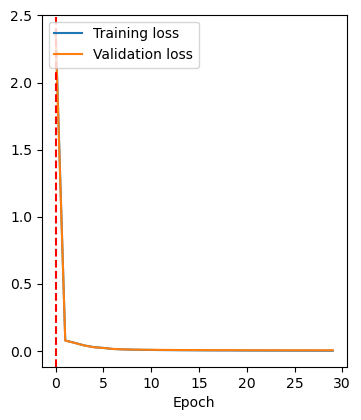

interactive(children=(SelectionSlider(description='Epoch:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,…

In [9]:
## Plot loss
loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
epochs = list(set(train_loss.index.get_level_values("Epoch")))

animation = SliderAnimation(
    {
        "Loss": EpochAnimation(
            graphs={
                "Training loss": train_loss,
                "Validation loss": val_loss,
            },
            unitless_graphs={},
        ),
    },
    parameters=epochs,
    parameter_name="Epoch",
    fig_size=4,
)

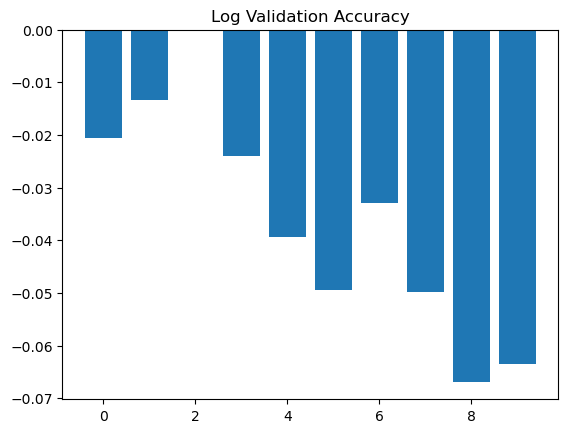

Validation Accuracy: 0.9654


In [10]:
## Evaluate
n_correct = np.zeros(10)
n_total = np.zeros(10)
for input, output in val_data:
    model_output = model(input)[0].detach().numpy()
    prediction = np.argmax(model_output)
    true = np.argmax(output)
    if prediction == true:
        n_correct[true] += 1
    n_total[true] += 1
plt.bar(np.arange(10), np.log(n_correct / n_total))
plt.title("Log Validation Accuracy")
plt.savefig(plot_path + f"log_val_acc_gain{gain}.png")
plt.show()
print(f"Validation Accuracy: {np.sum(n_correct)/np.sum(n_total)}")

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[ 1.0305644  -0.00882134 -0.0049659  -0.00176556 -0.0114989  -0.00684085
 -0.00452075 -0.00560528 -0.00514368 -0.00388759]


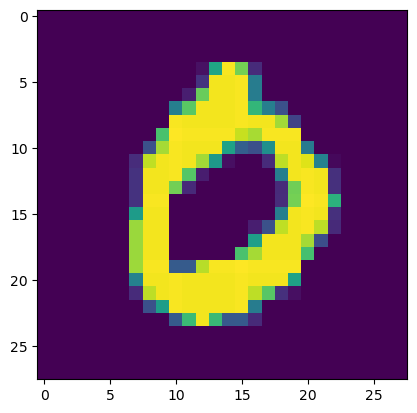

In [11]:
input, output = val_data[3]
print(output)
plt.imshow(input.cpu().reshape(28, 28))
print(model(input)[0].detach().numpy())

In [12]:
labels = np.array([np.argmax(output).item() for input, output in val_data])

for inputs, outputs in DataLoader(val_data, batch_size=len(val_data)):
    act = model(inputs)[1]
act = np.array([layer.detach().numpy() for layer in act])

In [13]:
@njit
def dist2(act1, act2):
    dist2 = []
    for layer in range(act1.shape[0]):
        if act1 is act2:
            n = len(act1[layer]) * len(act2[layer]) - 1
        else:
            n = len(act1[layer]) * len(act2[layer])
        distance = 0
        for point_1 in act1[layer]:
            for point_2 in act2[layer]:
                distance += np.linalg.norm(point_1 - point_2) / n
        dist2.append(distance)
    return np.array(dist2)

In [14]:
baseline = np.array(dist2(act, act))

100%|██████████| 10/10 [02:02<00:00, 12.28s/it]


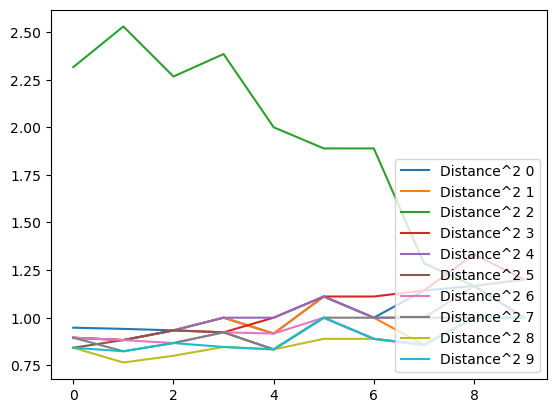

In [15]:
for n in trange(10):
    plt.plot(
        dist2(act[:, labels == n], act[:, labels != n]) / baseline,
        label=f"Distance^2 {n}",
    )
plt.legend(loc="lower right")
plt.savefig(plot_path + f"rel_feature_gain{gain}.png")
plt.show()

100%|██████████| 10/10 [02:01<00:00, 12.13s/it]


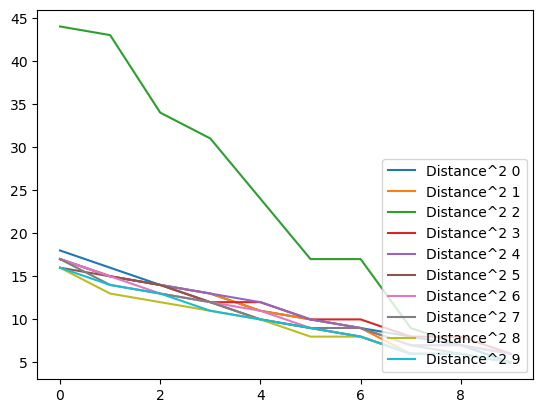

In [16]:
for n in trange(10):
    plt.plot(
        dist2(act[:, labels == n], act[:, labels != n]),
        label=f"Distance^2 {n}",
    )
plt.legend(loc="lower right")
plt.savefig(plot_path + f"feature_gain{gain}.png")
plt.show()